# Climate Analysis

In [1]:
#importing dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date, timedelta
import pandas as pd
from pandas import DataFrame

In [7]:
#importing SQLalchemy
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy.sql import func
from sqlalchemy import Column, Integer, String, Float, and_, Date, desc, func

In [3]:
#Creating the engine & connection
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)
conn = engine.connect()

In [4]:
#setting up the automap
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
#starting a session to query the database
session = Session(engine)

In [10]:
#Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [11]:
#Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [12]:
#collecting the start and end dates of the trips
date_entry = input('Enter a start date for your trip in YYYY-MM-DD format: ')
year, month, day = map(int, date_entry.split('-'))
start_date = datetime.date(year, month, day)

date_entry = input('Enter an end date for your trip in YYYY-MM-DD format: ')
year, month, day = map(int, date_entry.split('-'))
end_date = datetime.date(year, month, day)

Enter a start date for your trip in YYYY-MM-DD format: 2017-08-01
Enter an end date for your trip in YYYY-MM-DD format: 2017-08-23


# Precipitation Analysis

In [16]:
#Obtining a list of dates for the last 12 months
base_date = datetime.datetime.strptime(str(start_date), "%Y-%m-%d")
date_list = [base_date - datetime.timedelta(days=x) for x in range(0, 365)]

#Converting them to a list of strings
dates = []
for date in date_list:
    new_date = date.strftime("%Y-%m-%d")
    dates.append(new_date)

#print(dates)

In [20]:
#extracting the precipitation data
prcp_results = session.query(func.avg(Measurement.prcp), Measurement.date).filter(Measurement.date.in_(dates))\
               .group_by(Measurement.date)

#saving the precipitations to a list
prcp_data = []
for res in prcp_results:
    prcp_data.append(res[0])

#print(prcp_data)

In [23]:
#creating with the result a DataFrame
prcp_df = pd.DataFrame([dates[::-1], prcp_data[::-1]]).T
prcp_df.rename(columns={0: "Date", 1: "Precipitation"}, inplace=True)
prcp_df.set_index("Date", inplace=True)
print(prcp_df.head())
print(prcp_df.info())

           Precipitation
Date                    
2016-08-02         0.035
2016-08-03             0
2016-08-04          0.06
2016-08-05      0.101667
2016-08-06          0.11
<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2016-08-02 to 2017-08-01
Data columns (total 1 columns):
Precipitation    365 non-null object
dtypes: object(1)
memory usage: 5.7+ KB
None


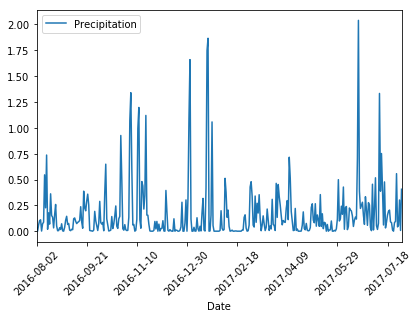

In [29]:
# Plotting data
prcp_df.plot()
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig("Images/Precipitation_Analysis.png")
plt.show()

In [31]:
#statistics summary
prcp_df.describe()

,Precipitation
count,365.0
unique,236.0
top,0.0
freq,46.0


# Station Analysis

In [32]:
#determining the number of stations
num_stations = session.query(Station.station).count()
print("The number of stations is: %s" % num_stations)

The number of stations is: 9


In [37]:
#query to find the observation counts by station
active_stations = session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station)\
             .order_by(func.count(Measurement.prcp).desc())

#printing the stations
for station in active_stations:
    print(station)

print("The most active station is: %s" % active_stations[0][0])
print("Number of observations for the most active station is %s" % active_stations[0][1])

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
The most active station is: USC00519281
Number of observations for the most active station is 2772


In [41]:
#extraxting the tobs info of the last 12 months for the top station
tobs_results = session.query(Measurement.tobs)\
               .filter(Measurement.date.in_(dates))\
               .filter(Measurement.station == active_stations[0][0])
        
#storing the result in a list
tobs_data = []
for row in tobs_results:
    tobs_data.append(row[0])
    
#print(tobs_data)

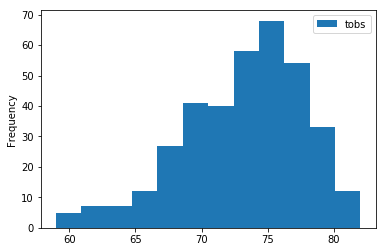

In [42]:
#plotting to tobs extracted in a histogram
plt.hist(tobs_data, bins=12, label='tobs')
plt.ylabel("Frequency")
plt.legend()
plt.savefig("Images/Station_Analysis.png")
plt.show()

# Temperature Analysis

In [44]:
#defining function calc_temps
def calc_temps (start_date, end_date):
    
    #converting the date time as in my data frame is like a VARCHAR
    startDate = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    startDate = startDate.replace(startDate.year - 1)
    endDate = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    endDate = endDate.replace(endDate.year - 1)
   
    
    #getting the date range
    delta = endDate - startDate
    date_range = []
    for i in range(delta.days + 1):
        date_range.append(startDate + timedelta(days=i))
        
    #converting the date range into strings for the filter
    date_range2 = []
    for date in date_range:
        new_date = date.strftime("%Y-%m-%d")
        date_range2.append(new_date)
        
    print(date_range2)
        
    # Grabbing avg, min & max temps    
    temp_avg = session.query(func.avg(Measurement.tobs))\
               .filter(Measurement.date.in_(date_range2))[0][0]
    temp_min = session.query(func.min(Measurement.tobs))\
               .filter(Measurement.date.in_(date_range2))[0][0]
    temp_max = session.query(func.max(Measurement.tobs))\
               .filter(Measurement.date.in_(date_range2))[0][0]
        
    return temp_avg, temp_min, temp_max

In [48]:
#calling the function for the dates of my trip
temp_analysis = calc_temps(str(start_date), str(end_date))

#creating the variables for min, max and avg variables
tavg = temp_analysis[0]
tmin = temp_analysis[1]
tmax = temp_analysis[2]
print(tavg)
print(tmin)
print(tmax)

['2016-08-01', '2016-08-02', '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14', '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18', '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22', '2016-08-23']
78.15436241610739
71
83


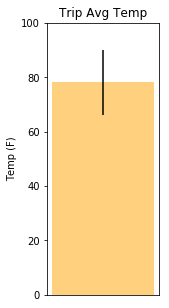

In [50]:
#creating the plot
plt.figure(figsize=(2,5))
plt.bar(1,height=tavg, yerr=(tmax-tmin), width=0.0001, alpha=0.5,color = 'orange')
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.savefig("Images/Temperature_Analysis.png")
plt.show()

# Optional Analysis - Daily Normals

In [54]:
#calcualting the total rainfall per weather station during my trip dates
total_prcp = session.query(Measurement.station, func.sum(Measurement.prcp)).filter(Measurement.date.in_(dates))\
            .group_by(Measurement.station).all()

total_prcp_df = pd.DataFrame(total_prcp, columns=["Station", "Total Precipitation from %s to %s" % (start_date, end_date)])
total_prcp_df.head(num_stations)

,Station,Total Precipitation from 2017-08-01 to 2017-08-23
0,USC00513117,52.04
1,USC00514830,34.26
2,USC00516128,155.70
3,USC00517948,4.77
4,USC00519281,75.96
5,USC00519397,17.12
6,USC00519523,39.26


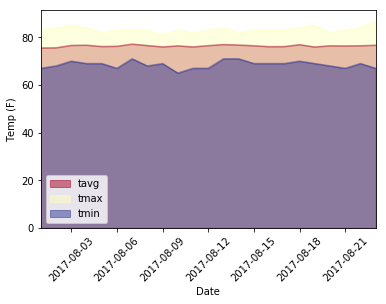

In [57]:
#creating a function to calculate the daily normals for my trip
def daily_normals(day):
    s_month = day.strftime('%m')
    s_day = day.strftime('%d')
    
    #extracting the maximum temperature
    max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date.like("%%%%-"+ s_month + "-" + s_day)).all()
    maximum = max_temp[0][0]
    
    #extracting the minimum temperature
    min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date.like("%%%%-"+ s_month + "-" + s_day)).all()
    minimum = min_temp[0][0]
    
    #extracting the average temperature
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date.like("%%%%-"+ s_month + "-" + s_day)).all()
    average = avg_temp[0][0]
    
    return maximum, minimum, average

#obtaining the range of dates for the chart
start = start_date
delta = datetime.timedelta(days=1)
date_range = []
while start <= end_date:
    date_range.append(start)
    start += delta

#print(date_range)

#getting the max/min/avg of each day
ranges = []

# get the max/min/avg for each day using a for loop, store in dict
for date in date_range:
    m,mi,av = daily_normals(date)
    ranges.append({"Date": date, "tmax": m, "tmin": mi, "tavg":av})
    
#print(ranges)
    
#creating a dataframe from the dictionary
date_df = pd.DataFrame(ranges)

#setting up the plot
date_df.plot.area(x = date_df["Date"], stacked = False, colormap='RdYlBu')
plt.ylabel("Temp (F)")
plt.xticks(rotation=45)
plt.savefig("Images/Daily_Normals.png")
plt.show()